# **Modelo de irradiância incidente**

Este notebook apresenta a implementação de um modelo de irradiância incidente considerando parâmetros atmosféricos e condição de céu limpo (_clear sky_).

**Autores:** Ana Clara da Cruz Silva, Bruno Rech | **Criado em:** 2025-01-19

* * *

### Biliotecas requeridas

Caso as bibliotecas requeridas não estejam instaladas, execute a célula abaixo. Adicione eventuais outras bibliotecas que possam ser requeridas e que não estejam instaladas.

In [ ]:
!pip install earthengine-api seaborn pvlib geemap

**Atenção:** no primeiro acesso ao GEE é preciso realizar login e gerar um token. Esse processo exige que um projeto tenha sido criado no Google Cloud. O token expira a cada 7 dias.

In [31]:
# Importar
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pvlib import spectrum, solarposition, irradiance, atmosphere

# Carregar funções auxiliares
%run funcoes_auxiliares.ipynb

### Preparação dos dados de campo

Os dados de campo vêm em formato CSV e precisam ser ajustados. A função utilizada está definida no notebook de funções auxiliares.

In [18]:
# Carregar dados
es = openFieldData('es_21122023.csv', equipment='satlantic')

es.head()

,12:42,13:12,13:33,13:59,14:13,14:31,16:45,wl
0,0.544159,0.593265,0.604905,0.679392,0.580461,0.714478,0.584489,360
1,0.554770,0.605154,0.617199,0.693202,0.591596,0.729324,0.596212,361
2,0.569146,0.620614,0.632742,0.711172,0.607525,0.748171,0.611153,362
3,0.583917,0.636478,0.649108,0.729557,0.623592,0.767214,0.626626,363
4,0.598499,0.652528,0.665025,0.747614,0.639944,0.786412,0.642185,364


### Parâmetros atmosféricos

As informações da atmosfera são obtidas de produtos via GEE. Para tanto, informe as coordenadas e as data de interesse.

**Atenção:** o produto de profundidade óptica de aerossol (AOD) do MODIS possui lacunas. Dessa forma, é necessário informar o número de dias anteriores e posteriores à data inicial de interesse para cálculo da AOD média. Exemplo: `td_aod = 2` gerará uma média de 5 dias, isto é, desde o dia n - 2 até o dia n + 2.

Fique atento às saídas e verifique se a AOD foi recuperada corretamente. Caso negativo, aumente `td_aod` e execute novamente.

In [3]:
# Coordenadas (xmin, ymin, xmax, ymax)
coords = [-45.7464, -24.1379,
          -45.5779, -24.0574]

# Data (yyyy-mm-dd)
date = '2023-12-21'

# Timedelta para AOD (dias)
td_aod = 1

# Obtenção dos parâmetros
aod_550, ozone, water, pressure = atmParams(date,
                                           td_aod,
                                           coords)

AOD média na área de interesse: 0.192
Ozônio médio na área de interesse: 0.273 atm-cm
Água na atmosfera na área de interesse: 3.95 cm
Pressão atmosférica na área de interesse: 101320 Pa


### Implementação do modelo

Alguns dados ainda precisam ser obtidos ou fornecidos:

In [7]:
# Coordenadas de interesse com base no ROI
lat = np.mean([coords[1], coords[3]])
lon = np.mean([coords[0], coords[2]])

# Inclinação da superfície (água = 0)
tilt = 0

# Azimute (em relação ao norte)
# Como a inclinação é zero, o azimute não deve causar diferenças
azimuth = 0

# Albedo da superfície (água é baixo)
albedo = 0.1

# Horários para cálculo
times = [pd.to_datetime(f'{date} {t}', utc=True)
         for t in es.columns[:-1]]

# Posição do sol
solpos = solarposition.get_solarposition(times, lat, lon)

# Área de interesse
aoi = irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

# Massa de ar relativa ao nível do mar
relative_airmass = atmosphere.get_relative_airmass(solpos.apparent_zenith)

Finalmente, podemos gerar os espectros:

In [10]:
model_spec = spectrum.spectrl2(apparent_zenith=solpos.apparent_zenith,
                               aoi=aoi,
                               surface_tilt=tilt,
                               ground_albedo=albedo,
                               surface_pressure=pressure,
                               relative_airmass=relative_airmass,
                               precipitable_water=water,
                               ozone=ozone,
                               aerosol_turbidity_500nm=aod_550)

A princípio, nosso interesse é na irradiância total (direta + difusa) que atinge a superfície (pode-se pensar em analisar outras frações):

In [45]:
# Transformar em dataframe
esm = pd.DataFrame(model_spec['poa_global'])

# Nome das colunas é o horário de cada espectro
esm.columns = [t.strftime('%H:%M') for t in times]

# Atribuir comprimentos de onda
esm['wl'] = model_spec['wavelength']

# Filtrar comprimentos de onda no range medido em campo
esm = esm[(esm.wl >= es.wl.min()) & (esm.wl <= es.wl.max())]

esm.reset_index(drop=True, inplace=True)
esm.head()

,12:42,13:12,13:33,13:59,14:13,14:31,16:45,wl
0,0.564170,0.616723,0.646786,0.675649,0.687172,0.697719,0.623336,360.0
1,0.674396,0.736089,0.771318,0.805100,0.818576,0.830907,0.743842,370.0
2,0.689757,0.751704,0.787022,0.820855,0.834343,0.846681,0.759480,380.0
3,0.668008,0.726913,0.760452,0.792554,0.805345,0.817041,0.734300,390.0
4,0.985116,1.070444,1.118971,1.165385,1.183871,1.200770,1.081135,400.0


### Validação do modelo

Com a geração dos espectros modelados, podemos compará-los com os dados obtidos em campo a partir de uma série de métricas de erro:

In [48]:
# Arredondar comprimentos de onda do modelo
esm['wl'] = esm.wl.round().astype(int)

# Selecionar Es de campo nos comprimentos de onda do modelo
es_sel = es[[x in esm.wl.tolist()
             for x in es.wl]].reset_index()

# Calcular métricas de erro
error_metrics = errorMetrics(data=esm,
                             ref=es_sel,
                             colnames=es.columns[:-1])

error_metrics

,point,r,pvalue,mbe,mpe,mae,mape,rmse,rmspe,sam
0,12:42,0.992163,3.281507e-33,0.018733,0.016099,0.027716,0.023818,0.041568,0.035722,0.031650
1,13:12,0.992609,1.181097e-33,0.014420,0.011446,0.027429,0.021772,0.041284,0.032770,0.030283
2,13:33,0.992529,1.423898e-33,0.031693,0.024480,0.036816,0.028438,0.050664,0.039134,0.030516
3,13:59,0.990161,1.729347e-31,-0.123589,-0.082416,0.127942,0.085319,0.140495,0.093690,0.034707
4,14:13,0.992772,8.005331e-34,0.186313,0.154050,0.186313,0.154050,0.192260,0.158967,0.031445
5,14:31,0.987949,5.913150e-30,-0.171821,-0.108362,0.173235,0.109254,0.188570,0.118926,0.037333
6,16:45,0.992676,1.007475e-33,0.054646,0.044388,0.055876,0.045387,0.066176,0.053754,0.029669


Por fim, podemos gerar um gráfico dos espectros e algumas métricas de erro:

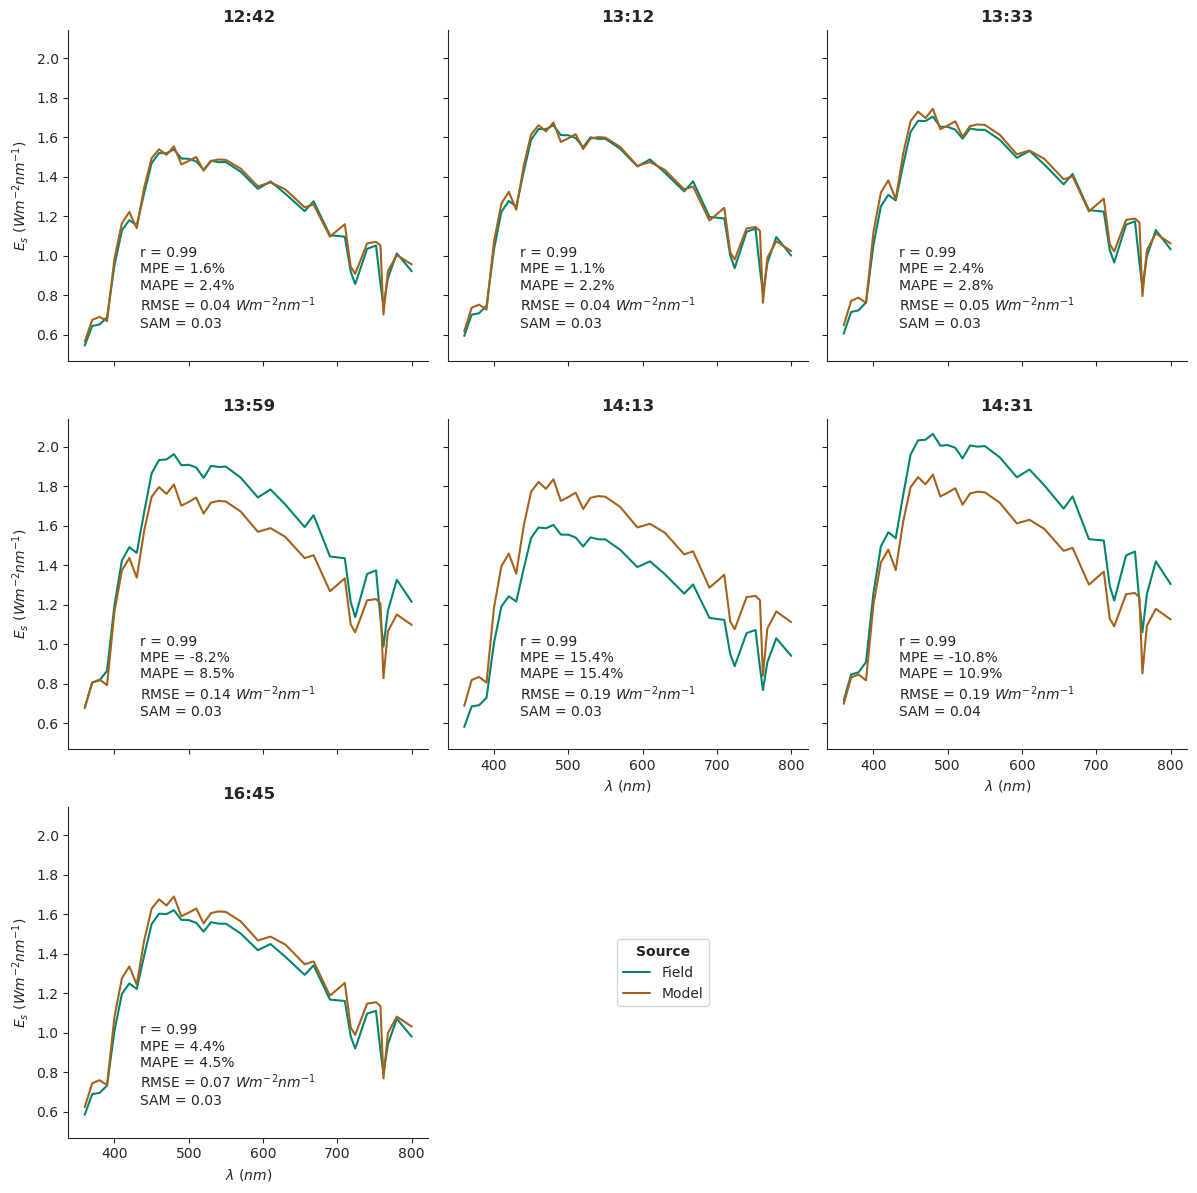

In [56]:
# Dataframes para formato longo
es_long = es_sel.melt(id_vars='wl',
                      var_name='time',
                      value_name='es')

esm_long = esm.melt(id_vars='wl',
                    var_name='time',
                    value_name='esm')

# Unir dataframes
es_plot = es_long.merge(esm_long, on=('wl', 'time'))

# Estilo do gráfico
sns.set_style('ticks')

# Criar grid
grid = sns.FacetGrid(data=es_plot, col='time', col_wrap=3,
                     sharex=True, sharey=True, aspect=1, height=4)

# Dados de campo
grid.map(sns.lineplot, 'wl', 'es',
         color='#018571', label='Field')

# dados do modelo
grid.map(sns.lineplot, 'wl', 'esm',
         color='#a6611a', label='Model')

# Título dos eixos
grid.set(xlabel='$\lambda ~ (nm)$',
         ylabel=r'$E_s ~ (Wm^{-2}nm^{-1})$')

# Legenda
plt.legend(title='Source', loc='right', bbox_to_anchor=(1.8, 0.5),
           title_fontproperties={'weight': 'bold'})

# Adicionar métricas de erro e título em cada subplot
for ax, r, mpe, mape, rmse, sam, t in zip(grid.axes.flatten(),
                                          error_metrics.r,
                                          error_metrics.mpe,
                                          error_metrics.mape,
                                          error_metrics.rmse,
                                          error_metrics.sam,
                                          error_metrics.point):

    # Adicionar métricas
    ax.annotate(f'r = {r:.2f}' +
                f'\nMPE = {mpe:.1%}' +
                f'\nMAPE = {mape:.1%}' +
                f'\nRMSE = {rmse:.2f}' + r' $Wm^{-2}nm^{-1}$' +
                f'\nSAM = {sam:.2f}',
                xy=(0.2, 0.1), xycoords='axes fraction')

    # Alterar título
    ax.set_title(t, weight='bold')